In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.7 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import Data
from torch.nn import Linear
from torch.nn import MSELoss
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import networkx as nx
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [3]:
!pip install openpyxl
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Microgrid Final Dataset.xlsx')
df

,Pd,Ps,Pw,H,D,Twpp,Tspp,Tt,Tesd,Tg,R,beta,Kvi,Dvi,Kp,Ki,lambda,Kd,mu,I
0,0.075393,0.000000,0.000000,0.083177,0.015750,1.503419,1.849900,0.395227,10.046667,0.100909,2.438265,1.065870,0.477816,3.828818,17.694268,11.758490,1.000000,0.412047,0.157532,0.035328
1,0.079872,0.000000,0.000000,0.085400,0.016148,1.475451,1.764980,0.411682,10.296349,0.099399,2.411765,0.994553,4.690227,2.109953,49.702018,46.356836,0.935626,20.712399,0.776399,0.041266
2,0.082034,0.000000,0.000000,0.086105,0.015095,1.542999,1.813313,0.413410,9.811683,0.093918,2.430978,0.975301,4.909423,4.934551,50.000000,25.745787,1.000000,16.025746,0.881452,0.028962
3,0.085009,0.000000,0.016461,0.080993,0.015866,1.436894,1.726528,0.407003,9.400160,0.098565,2.386173,0.924610,1.690911,4.752190,8.288606,50.000000,0.932459,29.367519,0.888890,0.013118
4,0.087932,0.000000,0.012346,0.080775,0.015128,1.461302,1.839761,0.405629,9.434244,0.102227,2.345033,0.986273,1.616732,5.000000,32.763975,1.755401,0.581781,38.206622,1.000000,0.059989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4564,0.119658,0.167640,0.000000,0.085246,0.014470,1.568313,1.773580,0.401548,9.718280,0.101530,2.387250,0.999900,0.000000,5.000000,48.206636,45.187972,1.000000,46.071080,0.122768,0.051967
4565,0.011795,0.155129,0.000000,0.082085,0.014104,1.461666,1.775713,0.400905,9.953465,0.103670,2.435674,0.959676,1.801692,3.849484,50.000000,50.000000,0.843376,50.000000,1.000000,0.045780
4566,0.116667,0.113428,0.004115,0.088922,0.015180,1.477259,1.783932,0.398166,9.583546,0.103688,2.410820,1.024954,1.353107,5.000000,36.242356,49.843793,1.000000,23.205984,0.894830,0.049256
4567,0.115385,0.069224,0.000000,0.085554,0.015543,1.454898,1.808729,0.391858,9.798691,0.099122,2.543315,0.894585,2.865833,4.245205,33.449608,35.469765,1.000000,50.000000,0.764979,0.042838


In [4]:
X = df.iloc[:, :12]  # First 12 columns
Y = df.iloc[:, 12:]  # Remaining 8 columns

# Print shapes to verify
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (4569, 12)
Y shape: (4569, 8)


In [7]:
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)


scaler_Y = MinMaxScaler()
Y_scaled = scaler_Y.fit_transform(Y)

In [8]:
# Convert to PyTorch tensors
X = torch.tensor(X_scaled, dtype=torch.float)
Y = torch.tensor(Y_scaled, dtype=torch.float)

In [15]:
node_id_cols = ['Pd','Ps','Pw','H','D','Twpp','Tesd','Tt','Tspp','Tg','R','beta']

In [10]:
src_type1, dst_type1 = node_id_cols[0], node_id_cols[3]
src_type2, dst_type2 = node_id_cols[0], node_id_cols[4]
src_type3, dst_type3 = node_id_cols[5], node_id_cols[3]
src_type4, dst_type4 = node_id_cols[5], node_id_cols[4]
src_type5, dst_type5 = node_id_cols[8], node_id_cols[3]
src_type6, dst_type6 = node_id_cols[8], node_id_cols[4]
src_type7, dst_type7 = node_id_cols[7], node_id_cols[3]
src_type8, dst_type8 = node_id_cols[7], node_id_cols[4]
src_type9, dst_type9 = node_id_cols[0], node_id_cols[1]
src_type10, dst_type10 = node_id_cols[0], node_id_cols[1]
src_type11, dst_type11 = node_id_cols[9], node_id_cols[7]
src_type12, dst_type12 = node_id_cols[1], node_id_cols[8]
src_type13, dst_type13 = node_id_cols[2], node_id_cols[5]
#src_type14, dst_type14 = node_id_cols[12], node_id_cols[3]
#src_type15, dst_type15 = node_id_cols[12], node_id_cols[4]
#src_type16, dst_type16 = node_id_cols[13], node_id_cols[3]
#src_type17, dst_type17 = node_id_cols[13], node_id_cols[4]
src_type18, dst_type18 = node_id_cols[10], node_id_cols[3]
src_type19, dst_type19 = node_id_cols[10], node_id_cols[4]
src_type20, dst_type20 = node_id_cols[11], node_id_cols[3]
src_type21, dst_type21 = node_id_cols[11], node_id_cols[4]
src_type22, dst_type22 = node_id_cols[10], node_id_cols[9]
src_type23, dst_type23 = node_id_cols[11], node_id_cols[9]
src_type24, dst_type24 = node_id_cols[3], node_id_cols[6]
src_type25, dst_type25 = node_id_cols[4], node_id_cols[6]


In [11]:
edges = [
    (src_type1, dst_type1), (src_type2, dst_type2), (src_type3, dst_type3), (src_type4, dst_type4),
    (src_type5, dst_type5), (src_type6, dst_type6), (src_type7, dst_type7), (src_type8, dst_type8),
    (src_type9, dst_type9), (src_type10, dst_type10), (src_type11, dst_type11), (src_type12, dst_type12),
    (src_type13, dst_type13),(src_type19, dst_type19), (src_type20, dst_type20),
    (src_type21, dst_type21), (src_type22, dst_type22), (src_type23, dst_type23),(src_type24, dst_type24),(src_type25, dst_type25)
]

num_edges = len(edges)
print(f"Number of edges: {num_edges}")

Number of edges: 20


In [12]:
print(edges)

[('Pd', 'H'), ('Pd', 'D'), ('Twpp', 'H'), ('Twpp', 'D'), ('Tspp', 'H'), ('Tspp', 'D'), ('Tt', 'H'), ('Tt', 'D'), ('Pd', 'Ps'), ('Pd', 'Ps'), ('Tg', 'Tt'), ('Ps', 'Tspp'), ('Pw', 'Twpp'), ('R', 'D'), ('beta', 'H'), ('beta', 'D'), ('R', 'Tg'), ('beta', 'Tg'), ('H', 'Tesd'), ('D', 'Tesd')]


In [17]:
node_to_idx = {node: idx for idx, node in enumerate(set(sum(edges, ())))}

#Convert the edge list to numerical indices
edges = [(node_to_idx[src], node_to_idx[dst]) for src, dst in edges]

# Print results
print("Mapped Edges:", edges)
# Count the edges
num_edges = len(edges)
print(f"Number of edges: {num_edges}")

Mapped Edges: [(11, 0), (11, 4), (3, 0), (3, 4), (2, 0), (2, 4), (8, 0), (8, 4), (11, 1), (11, 1), (6, 8), (1, 2), (10, 3), (5, 4), (7, 0), (7, 4), (5, 6), (7, 6), (0, 9), (4, 9)]
Number of edges: 20


In [18]:
print(node_to_idx)

{'H': 0, 'Ps': 1, 'Tspp': 2, 'Twpp': 3, 'D': 4, 'R': 5, 'Tg': 6, 'beta': 7, 'Tt': 8, 'Tesd': 9, 'Pw': 10, 'Pd': 11}


In [19]:
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

In [20]:
graph_data_list = []
for i in range(4569):
    # Node features for this row (shape: [num_nodes, 1])
    node_features = X[i].unsqueeze(1)  # Each feature is a node, so shape is [13, 1]

    # Targets for this row (shape: [num_output_features])
    targets = Y[i]

    # Create Data object
    data = Data(x=node_features, edge_index=edge_index, y=targets)
    graph_data_list.append(data)

# Now `graph_data_list` contains a graph for each row in your dataset
print(graph_data_list[0])

Data(x=[12, 1], edge_index=[2, 20], y=[8])


In [21]:
train_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)

In [22]:
class ImprovedGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.1):
        super(ImprovedGCN, self).__init__()
        # Deeper architecture with more capacity
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)  # Increase capacity
        self.conv3 = GCNConv(hidden_dim * 2, hidden_dim)  # Additional layer

        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim * 2)
        self.bn3 = torch.nn.BatchNorm1d(hidden_dim)

        # Adjusted fully connected layer for combined pooling
        self.fc = torch.nn.Linear(hidden_dim * 2, output_dim)  # *2 for mean + max pooling
        self.dropout = dropout

    def forward(self, x, edge_index, batch=None):
        # First GCN layer with batch norm and residual
        x0 = x  # Save input for potential residual (if dims match)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Second GCN layer with batch norm
        x1 = x  # Save for residual
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x, negative_slope=0.1)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Third GCN layer with residual connection
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        if x1.shape == x.shape:  # Ensure dimensions match for residual
            x = x + x1  # Residual connection
        x = F.leaky_relu(x, negative_slope=0.1)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Combined global pooling for graph-level tasks
        x = torch.cat([global_mean_pool(x, batch), global_max_pool(x, batch)], dim=1)

        # Output layer
        x = self.fc(x)
        return x

In [23]:
# Model parameters
input_dim = 1
hidden_dim = 64  # Increased from 16
output_dim = 8
batch_size = 1

# Initialize model
model = ImprovedGCN(input_dim, hidden_dim, output_dim, dropout=0.2)
print(model)

# Create data loaders (assuming train_data and test_data are defined)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Optimizer with adjusted parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Loss function
loss_fn = torch.nn.SmoothL1Loss()


ImprovedGCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 128)
  (conv3): GCNConv(128, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [24]:
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []

    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        batch.y = batch.y.view(out.shape)

        loss = loss_fn(out, batch.y)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

        all_preds.append(out.detach().cpu().numpy())
        all_targets.append(batch.y.detach().cpu().numpy())

    avg_train_loss = total_loss / len(train_loader)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            batch.y = batch.y.view(out.shape)
            loss = loss_fn(out, batch.y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)

    # Print the results for this epoch
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    mae = mean_absolute_error(all_targets, all_preds)
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

    # Update learning rate based on performance
    scheduler.step(avg_val_loss)


    # Early stopping check (implement if needed)
    #if avg_loss < 0.5:  # Example threshold
    #    print(f"Early stopping at epoch {epoch+1}")
     #   break

    # Validation step (implement if you have validation data)
    if (epoch+1) % 5 == 0:
        model.eval()
        # Implement validation code here

Epoch 1/20 | Train Loss: 0.0483 | Val Loss: 0.0430 | MAE: 0.2491 | RMSE: 0.3131
Epoch 2/20 | Train Loss: 0.0412 | Val Loss: 0.0424 | MAE: 0.2360 | RMSE: 0.2870
Epoch 3/20 | Train Loss: 0.0412 | Val Loss: 0.0457 | MAE: 0.2362 | RMSE: 0.2871
Epoch 4/20 | Train Loss: 0.0412 | Val Loss: 0.0397 | MAE: 0.2358 | RMSE: 0.2872
Epoch 5/20 | Train Loss: 0.0412 | Val Loss: 0.0415 | MAE: 0.2361 | RMSE: 0.2870
Epoch 6/20 | Train Loss: 0.0412 | Val Loss: 0.0410 | MAE: 0.2359 | RMSE: 0.2871
Epoch 7/20 | Train Loss: 0.0413 | Val Loss: 0.0437 | MAE: 0.2360 | RMSE: 0.2875
Epoch 8/20 | Train Loss: 0.0413 | Val Loss: 0.0405 | MAE: 0.2365 | RMSE: 0.2876
Epoch 9/20 | Train Loss: 0.0412 | Val Loss: 0.0394 | MAE: 0.2363 | RMSE: 0.2871
Epoch 10/20 | Train Loss: 0.0413 | Val Loss: 0.0437 | MAE: 0.2360 | RMSE: 0.2874
Epoch 11/20 | Train Loss: 0.0412 | Val Loss: 0.0402 | MAE: 0.2358 | RMSE: 0.2870
Epoch 12/20 | Train Loss: 0.0412 | Val Loss: 0.0417 | MAE: 0.2360 | RMSE: 0.2870
Epoch 13/20 | Train Loss: 0.0413 | Va

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(model, test_loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            out = model(batch.x, batch.edge_index)
            batch.y = batch.y.view(out.shape)

            loss = loss_fn(out, batch.y)
            total_loss += loss.item()

            all_preds.append(out.cpu().numpy())
            all_targets.append(batch.y.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

# === INVERSE SCALING ===
    # all_preds = scaler_Y.inverse_transform(all_preds)
    # all_targets = scaler_Y.inverse_transform(all_targets)

# Compute metrics on original scale
    avg_loss = total_loss / len(test_loader)
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    rmse = np.sqrt(mse)

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMsE: {rmse:.4f}")

    return avg_loss, mse, mae, rmse


In [32]:
test_loss, test_mse, test_mae, test_rmse = evaluate(model, test_loader)

Test Loss: 0.0398
MSE: 0.0796
MAE: 0.2394
RMsE: 0.2821


In [33]:
import networkx as nx
import matplotlib.pyplot as plt

In [34]:
edge_index_np = data.edge_index.numpy()
num_nodes = data.x.shape[0]

# Create a NetworkX graph
G = nx.Graph()
G.add_nodes_from(range(num_nodes))  # Add nodes
G.add_edges_from([(edge_index_np[0, i], edge_index_np[1, i]) for i in range(edge_index_np.shape[1])])

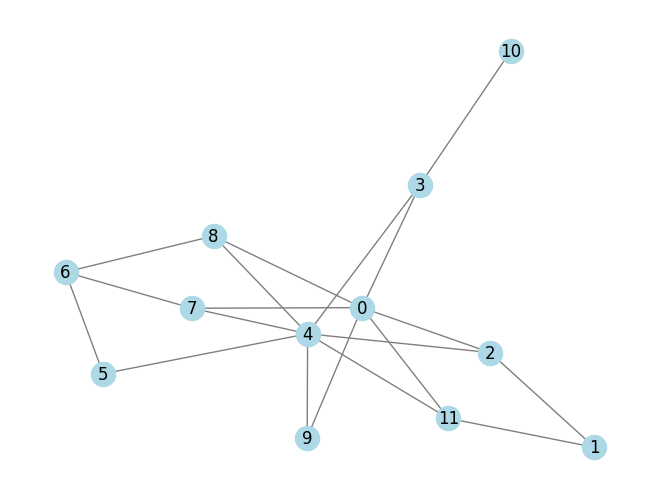

In [35]:
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()